# Find Cross Over Locations

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#import scipy.stats
#import contextily as cx
#from matplotlib_scalebar.scalebar import ScaleBar
import rasterio as rio
#from rasterio import features
#from rasterio.plot import show
#import rioxarray
#from astropy.time import Time
from datetime import datetime
import pickle
from rasterio import features
import hvplot.pandas
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts

import contextily as cx
basemap = cx.providers.Stamen.Terrain

### Load in the ICESat-2 SlideRule data:

In [2]:
atl06sr_gdf = pickle.load(open('../../../data/grmesa_20-40.pkl', 'rb'))

In [3]:
atl06sr_gdf = atl06sr_gdf.to_crs('epsg:32612')

In [61]:
atl06sr_gdf

,n_fit_photons,dh_fit_dy,h_sigma,cycle,spot,rgt,segment_id,pflags,w_surface_window_final,dh_fit_dx,distance,h_mean,rms_misfit,delta_time,gt,geometry,confidence,acqdate
time,,,,,,,,,,,,,,,,,,
2018-10-17 22:31:18.762338460,82,0.0,0.020675,1,1,295,216246,0,3.0,0.025475,4.336682e+06,1770.597407,0.185885,2.505068e+07,60,POINT (734118.254 4317991.903),4,2018-10-17
2018-10-17 22:31:18.765121812,92,0.0,0.017144,1,1,295,216247,0,3.0,0.024812,4.336702e+06,1771.111516,0.163035,2.505068e+07,60,POINT (734115.741 4318011.748),4,2018-10-17
2018-10-17 22:31:18.767913824,81,0.0,0.020705,1,1,295,216248,0,3.0,0.028081,4.336722e+06,1771.631947,0.176532,2.505068e+07,60,POINT (734113.222 4318031.639),4,2018-10-17
2018-10-17 22:31:18.770710484,47,0.0,0.027664,1,1,295,216249,0,3.0,0.034194,4.336743e+06,1772.230291,0.172267,2.505068e+07,60,POINT (734110.703 4318051.530),4,2018-10-17
2018-10-17 22:31:18.773512216,33,0.0,0.021143,1,1,295,216250,0,3.0,0.032571,4.336763e+06,1772.862377,0.121433,2.505068e+07,60,POINT (734108.188 4318071.422),4,2018-10-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07 23:39:21.158048752,31,0.0,0.054817,14,6,1156,785597,0,3.0,-0.013154,1.573497e+07,3081.818261,0.155629,1.319316e+08,60,POINT (749662.180 4317750.405),4,2022-03-07
2022-03-07 23:39:21.160135040,14,0.0,0.051428,14,4,1156,785592,0,3.0,0.005687,1.573487e+07,3032.877597,0.159723,1.319316e+08,40,POINT (752850.265 4317647.704),4,2022-03-07
2022-03-07 23:39:21.162953008,30,0.0,0.025192,14,4,1156,785593,0,3.0,0.008439,1.573489e+07,3033.013767,0.134948,1.319316e+08,40,POINT (752849.089 4317627.686),4,2022-03-07


### Load in the Grand Mesa UAVSAR shapefile

In [4]:
import os
import glob

path = '/home/jovyan/isce_sat2/data/uavsar_shape_files/'
extension = 'shp'
os.chdir(path)
shp_files = glob.glob('*.{}'.format(extension))
print(shp_files)

['grmesa_27416_21019-017_21021-005_0006d_s01_L090HH_01.cor.grd .shp', 'donner_03904_20014-003_20016-007_0014d_s01_L090HH_01.cor.grd .shp', 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd .shp', 'irnton_01406_21020-028_21022-002_0006d_s01_L090HH_01.cor.grd .shp', 'uticam_21003_21004-002_21013-003_0034d_s01_L090HH_01.cor.grd .shp', 'dorado_34017_20014-002_20016-000_0014d_s01_L090HH_01.cor.grd .shp', 'alamos_35915_20005-003_20008-000_0007d_s01_L090HH_01.cor.grd .shp', 'lowman_05208_21019-019_21021-007_0006d_s01_L090HH_01.cor.grd .shp', 'peeler_31619_20013-003_20017-008_0015d_s01_L090HH_01.cor.grd .shp', 'stlake_27129_21020-024_21022-001_0006d_s01_L090HH_01.cor.grd .shp', 'fraser_23306_21020-026_21021-004_0006d_s01_L090HH_01.cor.grd .shp', 'sierra_17305_20014-000_20016-005_0014d_s01_L090HH_01.cor.grd .shp', 'rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.cor.grd .shp']


In [5]:
final_gdf = gpd.GeoDataFrame(columns=['FID', 'geometry', 'site_name'])

In [6]:
for file in shp_files:
    dir = '/home/jovyan/isce_sat2/data/uavsar_shape_files/'
    path = dir + file
    #print(path)
    temp = gpd.read_file(path)
    
    temp['site_name'] = file.split('_')[0]
    
    final_gdf = final_gdf.append(temp)

/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final

In [7]:
final_gdf = final_gdf.set_crs('epsg:4326')
print(final_gdf.crs)

epsg:4326


In [8]:
final_gdf.head(2)

,FID,geometry,site_name
0,0,"POLYGON ((-108.25922 39.16208, -108.25899 39.1...",grmesa
0,0,"POLYGON ((-120.31301 39.53100, -120.31290 39.5...",donner


In [66]:
atl06sr_gdf['acqdate'] = atl06sr_gdf.index.date

In [9]:
atl06sr_gdf.head(2)

,n_fit_photons,dh_fit_dy,h_sigma,cycle,spot,rgt,segment_id,pflags,w_surface_window_final,dh_fit_dx,distance,h_mean,rms_misfit,delta_time,gt,geometry,confidence,acqdate
time,,,,,,,,,,,,,,,,,,
2018-10-17 22:31:18.762338460,82,0.0,0.020675,1,1,295,216246,0,3.0,0.025475,4.336682e+06,1770.597407,0.185885,2.505068e+07,60,POINT (734118.254 4317991.903),4,2018-10-17
2018-10-17 22:31:18.765121812,92,0.0,0.017144,1,1,295,216247,0,3.0,0.024812,4.336702e+06,1771.111516,0.163035,2.505068e+07,60,POINT (734115.741 4318011.748),4,2018-10-17


In [67]:
import datetime

march = atl06sr_gdf[atl06sr_gdf['acqdate'] == datetime.date(2020, 3, 11)]
feb = atl06sr_gdf[atl06sr_gdf['acqdate'] == datetime.date(2020, 2, 12)]

In [71]:
march.crs

<Derived Projected CRS: EPSG:32612>
Name: WGS 84 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 114°W and 108°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-114.0, 0.0, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

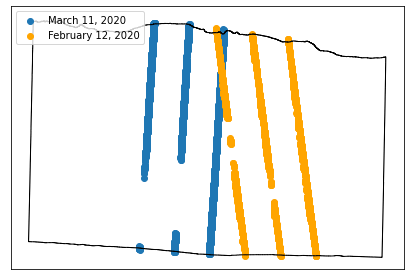

In [72]:
fig, ax = plt.subplots()

march.plot(ax=ax, label='March 11, 2020')
feb.plot(ax=ax, color='orange', label='February 12, 2020')
final_gdf[final_gdf['site_name'] == 'grmesa'].to_crs('epsg:32612').plot(ax=ax, facecolor='none')

plt.legend()
#ax.add_artist(ScaleBar(1))
#cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.tight_layout()
plt.savefig('coarse_crossovers.jpeg', dpi=300)

In [19]:
atl06sr_gdf['acqdate'].unique()

array([datetime.date(2018, 11, 15), datetime.date(2018, 12, 13),
       datetime.date(2019, 6, 12), datetime.date(2019, 9, 11),
       datetime.date(2019, 9, 13), datetime.date(2019, 10, 10),
       datetime.date(2019, 11, 14), datetime.date(2019, 12, 11),
       datetime.date(2020, 2, 12), datetime.date(2020, 3, 11),
       datetime.date(2020, 4, 9), datetime.date(2020, 4, 14),
       datetime.date(2020, 5, 13), datetime.date(2020, 6, 10),
       datetime.date(2020, 6, 11), datetime.date(2020, 7, 9),
       datetime.date(2020, 7, 14), datetime.date(2020, 8, 12),
       datetime.date(2020, 11, 11), datetime.date(2020, 12, 8),
       datetime.date(2020, 12, 10), datetime.date(2021, 1, 6),
       datetime.date(2021, 3, 9), datetime.date(2021, 5, 12),
       datetime.date(2021, 6, 8), datetime.date(2021, 8, 10),
       datetime.date(2021, 9, 7), datetime.date(2021, 10, 6),
       datetime.date(2021, 10, 11), datetime.date(2022, 2, 8),
       datetime.date(2022, 3, 7)], dtype=object)

## Compute Cross Overs

In [53]:
march_buffered = march
feb_buffered = feb

march_buffered.geometry = march.geometry.buffer(2.5)
feb_buffered.geometry = feb.geometry.buffer(2.5)

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [54]:
xover = gpd.overlay(march_buffered, feb_buffered, how='intersection')

In [15]:
len(xover)

2

In [55]:
xover['xover_diff'] = xover['h_mean_1'] - xover['h_mean_2']

In [32]:
xover

,n_fit_photons_1,dh_fit_dy_1,h_sigma_1,cycle_1,spot_1,rgt_1,segment_id_1,pflags_1,w_surface_window_final_1,dh_fit_dx_1,...,dh_fit_dx_2,distance_2,h_mean_2,rms_misfit_2,delta_time_2,gt_2,confidence_2,acqdate_2,geometry,xover_diff
0,22,0.0,0.056914,6,6,1156,784810,0,3.000000,0.081592,...,-0.140924,4.351955e+06,2497.156707,0.303663,6.678518e+07,20,4,2020-02-12,"POLYGON ((751544.895 4333443.382, 751544.955 4...",0.764348
1,31,0.0,0.064538,6,6,1156,784811,0,3.429393,0.132330,...,-0.139861,4.351935e+06,2500.011759,0.236318,6.678518e+07,20,4,2020-02-12,"POLYGON ((751544.417 4333424.820, 751544.614 4...",0.224926


In [1]:
# fig, ax = plt.subplots(figsize=(10,10))
# xover.plot(ax=ax)
# #final_gdf[final_gdf['site_name'] == 'grmesa'].to_crs('epsg:32612').plot(ax=ax, facecolor='none')
# plt.xlim(751000,752000)
# plt.ylim(4333000,4334500)

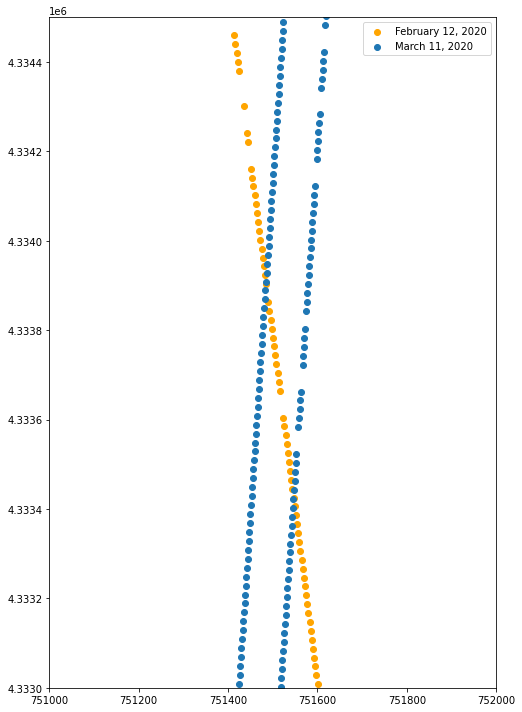

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
feb.plot(ax=ax, color='orange', label='February 12, 2020')
march.plot(ax=ax, label='March 11, 2020')
final_gdf[final_gdf['site_name'] == 'grmesa'].to_crs('epsg:32612').plot(ax=ax, markersize=100,facecolor='none')
plt.xlim(751000,752000)
plt.ylim(4333000,4334500)
plt.legend()
plt.tight_layout()
plt.savefig('crossovers_zoomed.jpeg',dpi=300)

<AxesSubplot:>

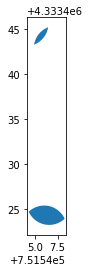

In [176]:
xover.plot()

In [ ]:
#Only run if ready to save an updated file

with open('../../../data/xover_initial.pkl', 'wb') as f:
    pickle.dump(xover, f)